In [1]:
import random, os, gc, pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})

from otto_utils import *

In [2]:
def run_lgbm(train, test, conf):
    seed_everything(conf.params['seed'])
    
    features = conf.features
    cat_features = conf.cat_features
    num_features = len(features)

    oof_predictions = np.zeros(len(train))
    feature_importance_df = pd.DataFrame()
    
    gt_sessions_ind = np.array(train[train[f'{conf.target[:-3]}_session']==1].index)
    ###
    train['r'] = np.random.randint(0, 5, train.shape[0])
    rand_ind = np.array(
        train[
            (train[f'{conf.target[:-3]}_gt']==1)
            | (train['r']==0)
        ].index
    )
    ###
    kfold = GroupKFold(n_splits = conf.n_folds)

    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[conf.target], train['session'])):
        print('\n'+'-'*50 + f'\nTraining fold {fold} with {num_features} features...\n')
        
        trn_ind_x = np.intersect1d(trn_ind, gt_sessions_ind, assume_unique=True)
        val_ind_x = np.intersect1d(val_ind, gt_sessions_ind, assume_unique=True)
        ###
        trn_ind_x = np.intersect1d(trn_ind_x, rand_ind, assume_unique=True)
        ###
        x_train_x, x_val_x = train[features].iloc[trn_ind_x], train[features].iloc[val_ind_x]
        y_train_x, y_val_x = train[conf.target].iloc[trn_ind_x], train[conf.target].iloc[val_ind_x]
        
        x_val = train[features].iloc[val_ind]
        y_val = train[conf.target].iloc[val_ind]
        
        lgb_train = lgb.Dataset(x_train_x, y_train_x, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val_x, y_val_x, categorical_feature = cat_features)
        
        model = lgb.train(
            params = conf.params,
            train_set = lgb_train,
            num_boost_round = conf.trees,
            valid_sets = [lgb_train, lgb_valid],
            categorical_feature = cat_features,
            callbacks=[
                log_evaluation(conf.verbose),
            ] if conf.params["boosting"]=="dart" else [
                log_evaluation(conf.verbose),
                early_stopping(conf.early,verbose=True)                
            ]
        )
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = model.feature_name()
        fold_importance_df["importance"] = model.feature_importance(importance_type='split')
        fold_importance_df["importance2"] = model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        val_pred = model.predict(x_val)
        oof_predictions[val_ind] = val_pred
        
        s = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': -1})
        s.loc[val_ind,'pred']=val_pred
        s = s[s['pred']>-0.5].copy()
        s = s.sort_values(['session','pred'],ascending=[True,False])
        s = s.reset_index(drop=True)
        s['n'] = s.groupby('session').cumcount()
        s = s[s['n']<20][['session','aid']].copy()
        
        test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
        test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
        test_labels = test_labels[test_labels['session'].isin(set(s['session']))].copy()
        test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
        test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
        denom = test_labels['num_gt'].sum()
        del test_labels['type'], test_labels['num_gt']
        test_labels = test_labels.explode('ground_truth')
        test_labels.columns = ['session','aid']
        nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))

        if conf.predict_test:
            test_predictions += model.predict(test[features]) / conf.n_folds
        
        score = roc_auc_score(y_val, val_pred)
        print(f'\nFold {fold} CV score is {score:.4f}')
        print(f'\nFold {fold} recall is {nom/denom:.6f}')
        print(f"nom={nom}; denom={denom}")
        
        save_object(model, f"models_new/lgb_{conf.target[:-3]}_{conf.trees}_tr_{conf.params['num_leaves']}_lv_{conf.params['boosting']}_fold_{fold}_{score:.4f}_{nom/denom:.6f}.pkl")
        
        del x_train_x, x_val_x, y_train_x, y_val_x, x_val, y_val, lgb_train, lgb_valid, s, test_labels
        gc_clear()
        
    oof = pd.DataFrame({'session': train['session'], 'aid': train['aid'], 'pred': oof_predictions})
    
    score = roc_auc_score(train[conf.target], oof_predictions)
    print(f'\nOut of folds CV score is {score:.4f}')
    
    s = oof.copy()
    s = s.sort_values(['session','pred'],ascending=[True,False])
    s = s.reset_index(drop=True)
    s['n'] = s.groupby('session').cumcount()
    s = s[s['n']<20][['session','aid']].copy()

    test_labels = pd.read_parquet('input/otto-validation/test_labels.parquet')
    test_labels = test_labels[test_labels['type']==conf.target[:-3]].copy()
    test_labels['num_gt'] = test_labels['ground_truth'].apply(len)
    test_labels['num_gt'] = np.where(test_labels['num_gt']>20,20,test_labels['num_gt'])
    denom = test_labels['num_gt'].sum()
    del test_labels['type'], test_labels['num_gt']
    test_labels = test_labels.explode('ground_truth')
    test_labels.columns = ['session','aid']
    nom = len(s.merge(test_labels, on=['session','aid'],how='inner'))
    print(f'\nOut of folds recall is {nom/denom:.6f}')
    print(f"nom={nom}; denom={denom}")
    
    save_object(oof_predictions, f"models_new/lgb_oof_{conf.target[:-3]}.pkl")
    
    if conf.predict_test:
        sub = pd.DataFrame({'session': test['session'], 'aid': test['aid'], 'pred': test_predictions})
    else:
        sub = None
        
    del s, test_labels, oof_predictions
    gc_clear()
        
    display_importances(feature_importance_df)
    feature_importance_df.to_csv(
        f"models_new/fe_lgb_{conf.target[:-3]}_{nom/denom:.6f}.csv",
        index=False
    )
    return oof, sub
    

def display_importances(feature_importance_df_):
    tops = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:80].index
    tops2 = feature_importance_df_[["feature", "importance2"]].groupby("feature").mean().sort_values(by="importance2", ascending=False)[:80].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops)]
    best_features2 = feature_importance_df_.loc[feature_importance_df_.feature.isin(tops2)]
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features Split (avg over folds)')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 15))
    sns.barplot(x="importance2", y="feature", data=best_features2.sort_values(by="importance2", ascending=False))
    plt.title('LightGBM Features Gain (avg over folds)')
    plt.tight_layout()
    plt.show()

In [3]:
train = pd.concat(
    [
        pd.read_parquet("feats/feats_0_batch_0_small.pqt"),
        pd.read_parquet("feats/feats_0_batch_1_small.pqt"),
        pd.read_parquet("feats/feats_0_batch_2_small.pqt"),
        pd.read_parquet("feats/feats_0_batch_3_small.pqt"),
    ],
    ignore_index=True
)
train

,session,aid,matrices_num,matrices_numsum,matrices_wgt_rel_mean,CA_estimation_frCL_trn,CA_estimation_frCL_tst,OR_estimation_frCA_trn,OR_estimation_frCL_trn,a2s_actions_num,a2s_actions_rel,a2s_best_action_type,a2s_carts_num,a2s_carts_rel,a2s_clicks_num,a2s_clicks_rel,a2s_last_action_index,a2s_last_cart_index,a2s_last_click_index,a2s_orders_rel,aid_CA2OR_trn,aid_CA_rank_int_tst_vs_trn,aid_CA_vs_mean_trn,aid_CA_vs_mean_tst,aid_CA_vs_mean_tst_vs_trn,aid_CL2CA_trn,aid_CL2CA_tst,aid_CL2OR_trn,aid_CL_rank_int_trn,aid_CL_rank_int_tst_vs_trn,aid_CL_rank_pct_tst_vs_trn,aid_CL_vs_mean_trn,aid_CL_vs_mean_tst_vs_trn,aid_clicks_favourite_dow_diff_test,aid_multi_clicks_percent_full,aid_multi_orders_percent_train,carts_rating_full,carts_rating_train,clicks_rating_full,clicks_rating_train,orders_rating_full,session_actions,session_avg_real_items_num,session_avg_real_length,session_carts,session_carts_avg_hour,session_carts_avg_real,session_click_diff_mean,session_clicks,session_full_length,session_items,session_items_carted,session_items_clicked,ts_diff,ts_diff_carts,ts_diff_carts_rel,ts_diff_clicks,ts_diff_clicks_rel,ts_diff_orders,ts_diff_orders_rel,ts_diff_rel,v11m_indmin,v11m_num,v21k_num,v21m_indmin,v31m_indmin,v31m_num,v51ha_indmin,wgt_rel_v11m_mean,wgt_rel_v11m_sum,wgt_rel_v21k_mean,wgt_rel_v21k_sum,wgt_rel_v21m_mean,wgt_rel_v21m_sum,wgt_rel_v31m_mean,wgt_rel_v31m_sum,wgt_rel_v51ha_mean,wgt_rel_v51ha_sum,wgt_v11m_mean,wgt_v11m_sum,wgt_v21k_sum,wgt_v21m_mean,wgt_v21m_sum,wgt_v31m_mean,wgt_v31m_sum,wgt_v51ha_mean,wgt_v51ha_sum,emb_diff_sh1_1_pub,emb_angle_sh1_1_pub,emb_diff_sh2_1_pub,emb_angle_sh2_1_pub,emb_diff_w2v,emb_angle_w2v,emb_diff_w2v_100,emb_angle_w2v_100,clicks_gt,carts_gt,orders_gt,clicks_session,carts_session,orders_session
0,12631600,557425,3,3,3.911101,0.234043,0.333333,0.0,0.092199,1,0.25,0,0,-1.0,1,0.25,3,999,3,-1.0,0.393939,0.664119,5.587123,4.594200,0.822284,0.234043,0.333333,0.092199,119882.5,0.844306,1.761760,2.555738,0.566216,1,0.193333,0.000000,57087,60338,120351,126423,53734,4,2.0,459.0,0,-1.000000,0.0,153.0,4,459,2,0,2,459,1661652309,3.612288e+06,459,9.978261e-01,1661652309,3.612288e+06,9.978261e-01,29,1,0,26,18,1,-1,0.018519,0.018519,-1.0,-1.0,0.006494,0.006494,0.027505,0.027505,-1.000000,-1.000000,1.0,1.0,-1.0,1.0,1.0,3.911101,3.911101,-1.0,-1.0,22.141920,0.762018,14.819950,0.952738,6.655867,0.887109,29.609187,0.579954,0,0,0,0,0,0
1,12631600,36760,0,0,-5.000000,0.750000,0.000000,0.0,0.000000,3,0.75,0,0,-1.0,3,0.75,0,999,0,-1.0,0.000000,0.611522,0.169307,0.000000,0.000000,0.250000,0.000000,0.000000,1500665.5,0.266547,0.556187,0.072503,4.435363,0,0.333333,-1.000000,1086474,792477,1145432,1443488,2000000,4,2.0,459.0,0,-1.000000,0.0,153.0,4,459,2,0,2,0,1661652309,3.612288e+06,0,0.000000e+00,1661652309,3.612288e+06,0.000000e+00,-1,0,0,-1,-1,0,-1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,0,0,0
2,12632800,1711787,0,0,-5.000000,0.181034,0.083333,0.0,0.025862,1,1.00,0,0,-1.0,1,1.00,0,999,0,-1.0,0.142857,1.737008,3.555442,1.531400,0.430720,0.181034,0.083333,0.025862,143125.0,0.529597,1.105076,2.102593,0.917661,0,0.359375,0.000000,70495,69928,95874,97382,209762,1,1.0,0.0,0,-1.000000,0.0,-1.0,1,0,1,0,1,0,1661656907,1.661657e+09,0,0.000000e+00,1661656907,1.661657e+09,0.000000e+00,-1,0,0,-1,-1,0,-1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,0,0,0
3,12638000,89997,0,0,-5.000000,0.525424,0.255952,0.0,0.371671,1,1.00,0,0,-1.0,1,1.00,0,999,0,-1.0,0.707373,0.373392,73.479127,65.850195,0.896176,0.525424,0.255952,0.371671,17249.0,0.166502,0.347430,14.971915,1.804215,0,0.190141,0.058632,1780,1926,16326,18982,656,1,1.0,0.0,0,-1.000000,0.0,-1.0,1,0,1,0,1,0,1661665241,1.661665e+09,0,

In [4]:
sirius_bigram = pd.read_parquet("matrices/bigram_train_sirius.parquet")
train = train.merge(
    sirius_bigram,
    on=['session','aid'],
    how='left'
)
sirius_bigram
gc_clear()

bigram_feats = [
    'bigram_normed_clicks_sum', 'bigram_normed_clicks_mean', 'bigram_normed_clicks_max', 'bigram_normed_clicks_min', 
    'bigram_normed_clicks_last', 'bigram_normed_carts_sum', 'bigram_normed_carts_mean', 'bigram_normed_carts_max', 
    'bigram_normed_carts_min', 'bigram_normed_carts_last', 'bigram_more_clicks_sum', 'bigram_more_clicks_mean', 
    'bigram_more_clicks_max', 'bigram_more_clicks_min', 'bigram_more_clicks_last', 'bigram_more_carts_sum', 
    'bigram_more_carts_mean', 'bigram_more_carts_max', 'bigram_more_carts_min', 'bigram_more_carts_last' 
]

In [6]:
train['bpr'] = pd.read_parquet("matrices/bpr_train_small.parquet")['bpr']

In [7]:
feats = []
catfeats = []
class CFG:
    def __init__(self):
        self.n_folds = 3
        self.trees = 1000
        self.early = 100
        self.verbose = 50
        self.params = {
            'objective': 'binary',
            #'metric': 'auc',
            'boosting': 'gbdt',
            'seed': 42,
            'num_leaves': 16,
            'learning_rate': 0.05,
            'feature_fraction': 0.80,
            'n_jobs': -1,
            'lambda_l2': 2,
            'min_data_in_leaf': 50,
        }
        self.target = 'clicks_gt'
        self.features = feats
        self.cat_features = catfeats
        self.predict_test = False

In [8]:
out_dict = {
    'orders': [
        'a2s_actions_rel', 'a2s_best_action_type', 'a2s_actions_num', 'a2s_last_action_index', 'ts_diff',
        'a2s_carts_rel', 'a2s_last_click_index', 'a2s_last_cart_index', 'a2s_carts_num', 'wgt_v51ha_sum',
        'OR_estimation_frCA_trn', 'aid_CL2OR_trn', 'ts_diff_clicks', 'wgt_v21m_sum', 'session_actions',
        'session_carts', 'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'wgt_rel_v51ha_sum',
        'wgt_rel_v21m_sum', 'wgt_v31m_sum', 'session_carts_avg_real', 'ts_diff_carts', 'ts_diff_orders_rel',
        'a2s_clicks_rel', 'OR_estimation_frCL_trn', 'session_clicks', 'carts_rating_full', 'ts_diff_clicks_rel',
        'session_carts_avg_hour', 'ts_diff_carts_rel', 'ts_diff_rel', 'wgt_rel_v31m_sum', 'wgt_rel_v21m_mean',
        'session_full_length', 'aid_CL2CA_tst', 'aid_CA2OR_trn', 'v21m_indmin', 'a2s_orders_rel',
        'session_items_carted', 'aid_CA_rank_int_tst_vs_trn', 'session_avg_real_length', 'ts_diff_orders',
        'carts_rating_train', 'v21k_num', 'wgt_v51ha_mean', 'orders_rating_full', 'aid_multi_orders_percent_train',
        'aid_multi_clicks_percent_full'
    ],
    'carts': [
        'a2s_last_action_index', 'ts_diff', 'a2s_actions_rel', 'ts_diff_rel', 'wgt_v51ha_sum', 'wgt_v21m_sum',
        'wgt_rel_v21m_sum', 'wgt_rel_v51ha_sum', 'session_clicks', 'wgt_v31m_sum', 'a2s_clicks_rel',
        'wgt_rel_v51ha_mean', 'wgt_v21k_sum', 'v51ha_indmin', 'session_items_clicked', 'wgt_rel_v31m_sum',
        'session_items', 'v21m_indmin', 'wgt_rel_v21k_sum', 'wgt_v11m_sum', 'a2s_last_click_index', 
        'wgt_rel_v21m_mean', 'aid_CL2CA_tst', 'ts_diff_carts_rel', 'CA_estimation_frCL_trn', 'aid_CL2CA_trn',
        'ts_diff_clicks_rel', 'clicks_rating_train', 'ts_diff_orders_rel', 'aid_CL_vs_mean_trn', 'ts_diff_clicks',
        'aid_CL_rank_int_tst_vs_trn', 'session_full_length', 'aid_multi_clicks_percent_full', 'wgt_v51ha_mean',
        'session_avg_real_items_num', 'a2s_actions_num', 'aid_CL_rank_int_trn', 'v31m_num', 'v31m_indmin',
        'a2s_clicks_num', 'CA_estimation_frCL_tst', 'wgt_rel_v21k_mean', 'aid_CL_vs_mean_tst_vs_trn',
        'aid_CL_rank_pct_tst_vs_trn', 'aid_CA_rank_int_tst_vs_trn', 'aid_CA_vs_mean_tst', 'clicks_rating_full',
        'session_click_diff_mean', 'aid_CA_vs_mean_tst_vs_trn'
    ],
    'clicks': [
        'a2s_last_action_index', 'a2s_actions_rel', 'ts_diff', 'session_actions', 'wgt_rel_v31m_mean', 
        'wgt_v31m_sum', 'wgt_rel_v11m_mean', 'v31m_indmin', 'wgt_rel_v31m_sum', 'wgt_v11m_sum', 'v11m_indmin',
        'session_items', 'session_clicks', 'session_full_length', 'wgt_v11m_mean', 'aid_CL_rank_int_tst_vs_trn',
        'wgt_v31m_mean', 'ts_diff_carts_rel', 'ts_diff_rel', 'aid_CL_vs_mean_tst_vs_trn', 'a2s_actions_num',
        'session_avg_real_items_num', 'v31m_num', 'ts_diff_orders_rel', 'ts_diff_clicks_rel', 
        'session_items_clicked', 'aid_multi_clicks_percent_full', 'aid_CL_rank_pct_tst_vs_trn', 'wgt_v51ha_sum',
        'aid_CL_vs_mean_trn', 'v21k_num', 'wgt_rel_v21k_sum', 'wgt_v21m_sum', 'carts_rating_train', 'wgt_v21m_mean', 
        'wgt_rel_v11m_sum', 'aid_CA_vs_mean_trn', 'ts_diff_clicks', 'wgt_v21k_sum', 'v11m_num', 
        'a2s_last_click_index', 'clicks_rating_full', 'wgt_rel_v21k_mean', 'clicks_rating_train', 
        'aid_clicks_favourite_dow_diff_test', 'a2s_carts_rel', 'wgt_rel_v21m_mean', 'wgt_v51ha_mean', 
        'wgt_rel_v51ha_mean', 'CA_estimation_frCL_trn'
    ]
}

In [9]:
pub_sh1_1 = ['emb_diff_sh1_1_pub','emb_angle_sh1_1_pub']
pub_sh2_1 = ['emb_diff_sh2_1_pub','emb_angle_sh2_1_pub']
w2v = ['emb_diff_w2v_100','emb_angle_w2v_100']
bpr = ['bpr']

embs_feats = pub_sh1_1 + pub_sh2_1 + w2v + bpr + bigram_feats


--------------------------------------------------
Training fold 0 with 80 features...

[LightGBM] [Info] Number of positive: 207771, number of negative: 5841870
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17835
[LightGBM] [Info] Number of data points in the train set: 6049641, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034344 -> initscore=-3.336370
[LightGBM] [Info] Start training from score -3.336370
[50]	training's binary_logloss: 0.11117	valid_1's binary_logloss: 0.0788404
[100]	training's binary_logloss: 0.101858	valid_1's binary_logloss: 0.0693121
[150]	training's binary_logloss: 0.0984122	valid_1's binary_logloss: 0.0662698
[200]	training's binary_logloss: 0.0967995	valid_1's binary_logloss: 0.0648555
[250]	training's binary_logloss:

[50]	training's binary_logloss: 0.111346	valid_1's binary_logloss: 0.0789032
[100]	training's binary_logloss: 0.102022	valid_1's binary_logloss: 0.0693678
[150]	training's binary_logloss: 0.0985794	valid_1's binary_logloss: 0.0663336
[200]	training's binary_logloss: 0.0969732	valid_1's binary_logloss: 0.0649313
[250]	training's binary_logloss: 0.0852461	valid_1's binary_logloss: 0.050027
[300]	training's binary_logloss: 0.080621	valid_1's binary_logloss: 0.0438784
[350]	training's binary_logloss: 0.0782932	valid_1's binary_logloss: 0.0409168
[400]	training's binary_logloss: 0.0778464	valid_1's binary_logloss: 0.0407873
[450]	training's binary_logloss: 0.0776771	valid_1's binary_logloss: 0.0408519
[500]	training's binary_logloss: 0.0754374	valid_1's binary_logloss: 0.0372405
[550]	training's binary_logloss: 0.0749735	valid_1's binary_logloss: 0.0366824
[600]	training's binary_logloss: 0.074684	valid_1's binary_logloss: 0.0363676
[650]	training's binary_logloss: 0.0740166	valid_1's binar

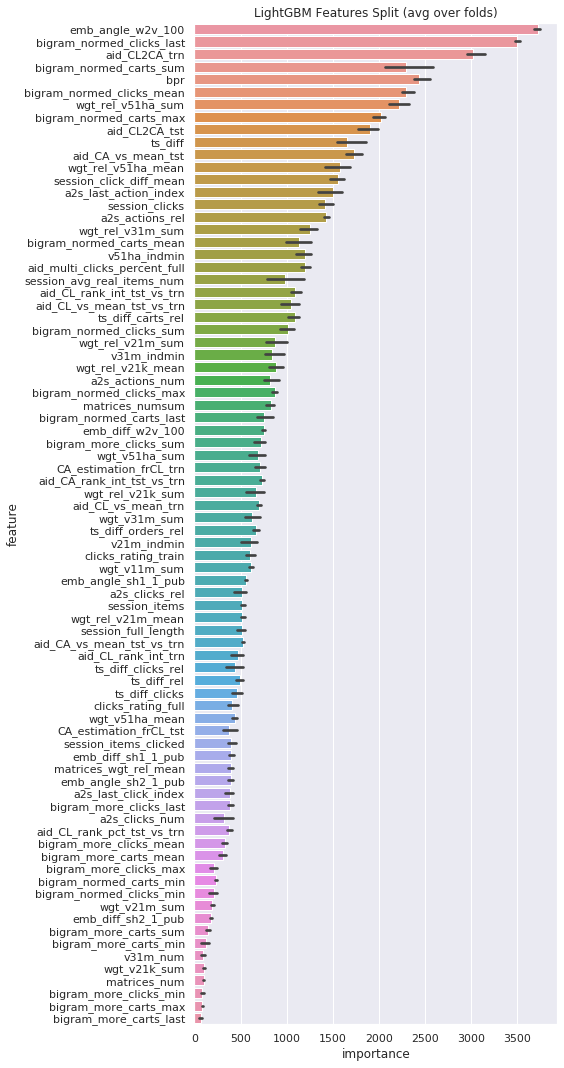

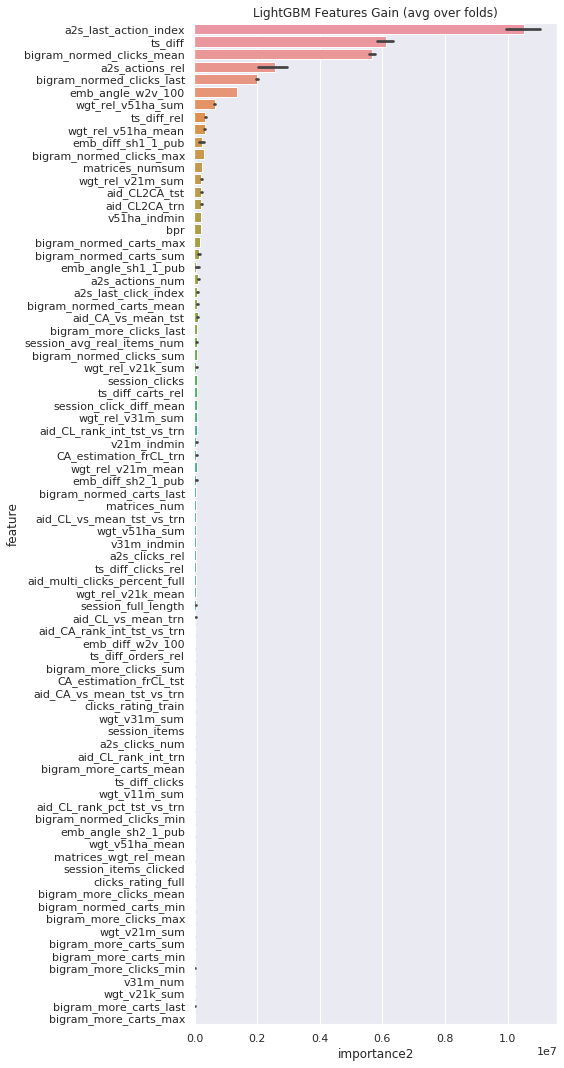

In [17]:
C1 = CFG()

C1.trees = 2000
C1.early = 500
C1.params['boosting'] = 'dart'
C1.params['num_leaves'] = 36
C1.params['min_data_in_leaf'] = 20

C1.features = out_dict['carts'] + [
    'matrices_num','matrices_numsum','matrices_wgt_rel_mean'
] + embs_feats
C1.cat_features = ['a2s_best_action_type'] if ('a2s_best_action_type' in C1.features) else []
C1.target = 'carts_gt'

carts_oof, _ = run_lgbm(train, None, C1)

In [18]:
train['carts_pred'] = carts_oof['pred']


--------------------------------------------------
Training fold 0 with 78 features...

[LightGBM] [Info] Number of positive: 152446, number of negative: 4035278
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.491786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16878
[LightGBM] [Info] Number of data points in the train set: 4187724, number of used features: 78


/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036403 -> initscore=-3.276020
[LightGBM] [Info] Start training from score -3.276020
Training until validation scores don't improve for 500 rounds
[50]	training's binary_logloss: 0.0798911	valid_1's binary_logloss: 0.0381575
[100]	training's binary_logloss: 0.0623676	valid_1's binary_logloss: 0.030185
[150]	training's binary_logloss: 0.0541529	valid_1's binary_logloss: 0.0260592
[200]	training's binary_logloss: 0.049871	valid_1's binary_logloss: 0.0238448
[250]	training's binary_logloss: 0.0476191	valid_1's binary_logloss: 0.0226711
[300]	training's binary_logloss: 0.0463524	valid_1's binary_logloss: 0.0220267
[350]	training's binary_logloss: 0.0456265	valid_1's binary_logloss: 0.0216665
[400]	training's binary_logloss: 0.0451838	valid_1's binary_logloss: 0.0214566
[450]	training's binary_logloss: 0.0448941	valid_1's binary_logloss: 0.021324
[500]	training's binary_logloss: 0.0446894	valid_1's binary_logloss: 0.0212336
[550]	training's b

/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036266 -> initscore=-3.279946
[LightGBM] [Info] Start training from score -3.279946
Training until validation scores don't improve for 500 rounds
[50]	training's binary_logloss: 0.079595	valid_1's binary_logloss: 0.0382061
[100]	training's binary_logloss: 0.0621212	valid_1's binary_logloss: 0.0302665
[150]	training's binary_logloss: 0.0539367	valid_1's binary_logloss: 0.0261687
[200]	training's binary_logloss: 0.0496634	valid_1's binary_logloss: 0.0239698
[250]	training's binary_logloss: 0.0474094	valid_1's binary_logloss: 0.0228089
[300]	training's binary_logloss: 0.0461404	valid_1's binary_logloss: 0.0221737
[350]	training's binary_logloss: 0.0454111	valid_1's binary_logloss: 0.0218199
[400]	training's binary_logloss: 0.0449716	valid_1's binary_logloss: 0.0216158
[450]	training's binary_logloss: 0.0446835	valid_1's binary_logloss: 0.0214875
[500]	training's binary_logloss: 0.0444818	valid_1's binary_logloss: 0.0213999
[550]	training's

/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/alvor/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036514 -> initscore=-3.272863
[LightGBM] [Info] Start training from score -3.272863
Training until validation scores don't improve for 500 rounds
[50]	training's binary_logloss: 0.0801912	valid_1's binary_logloss: 0.0381826
[100]	training's binary_logloss: 0.0626426	valid_1's binary_logloss: 0.0302296
[150]	training's binary_logloss: 0.0544188	valid_1's binary_logloss: 0.0261174
[200]	training's binary_logloss: 0.0501276	valid_1's binary_logloss: 0.0239052
[250]	training's binary_logloss: 0.0478646	valid_1's binary_logloss: 0.0227301
[300]	training's binary_logloss: 0.0465958	valid_1's binary_logloss: 0.0220895
[350]	training's binary_logloss: 0.0458683	valid_1's binary_logloss: 0.0217312
[400]	training's binary_logloss: 0.0454306	valid_1's binary_logloss: 0.0215255
[450]	training's binary_logloss: 0.0451371	valid_1's binary_logloss: 0.0213942
[500]	training's binary_logloss: 0.0449282	valid_1's binary_logloss: 0.0213025
[550]	training'

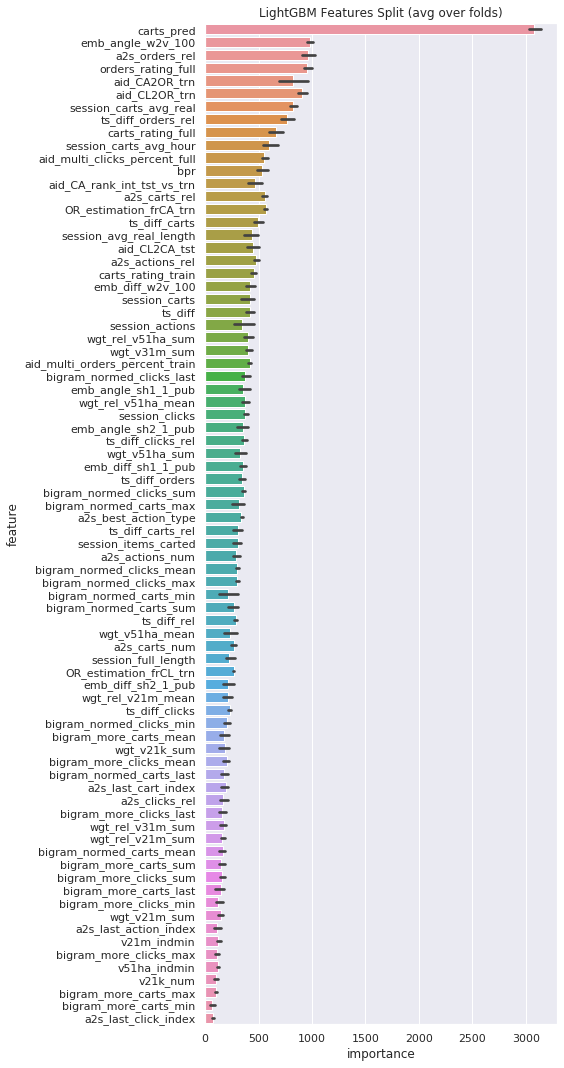

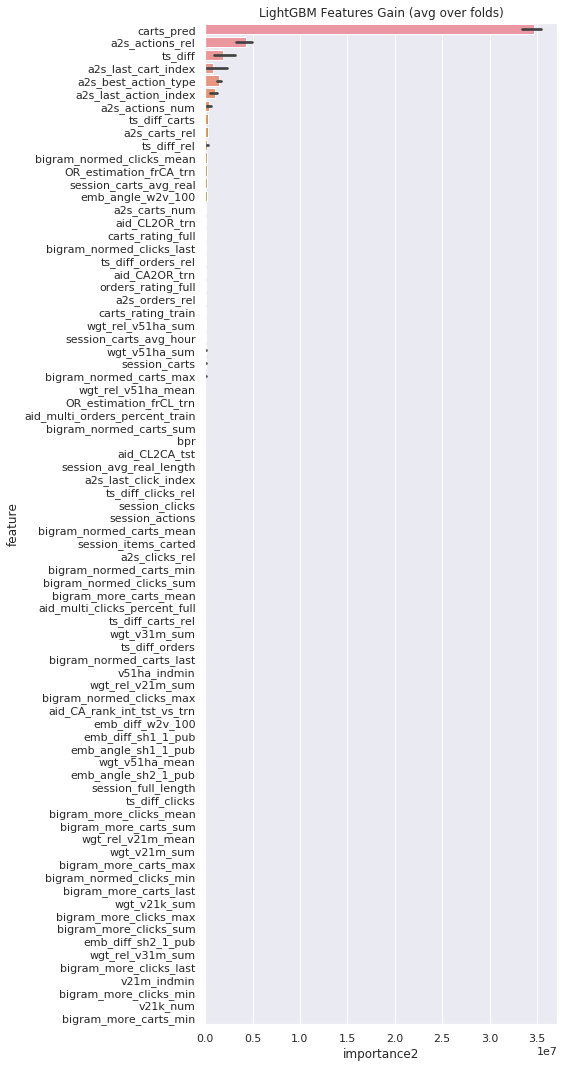

In [19]:
C1 = CFG()

C1.trees = 2000
C1.early = 500
C1.params['learning_rate'] = 0.01
C1.params['num_leaves'] = 16
C1.params['min_data_in_leaf'] = 20

C1.features = out_dict['orders'] + [
    'carts_pred'
] + embs_feats
C1.cat_features = ['a2s_best_action_type'] if ('a2s_best_action_type' in C1.features) else []
C1.target = 'orders_gt'

orders_oof, _ = run_lgbm(train, None, C1)